In [2]:
import csv
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from collections import Counter
import scipy.integrate as spi
import scipy.optimize as opt
import time

## Extract Ebola data

In [3]:
dates_ebola = []
countries_ebola = []
with open('ebola_sorted.csv', 'r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip the header row
    for row in reader:
        countries_ebola.append(row[0])
        dates_ebola.append(row[4])

data = {
    'Country': countries_ebola,
    'Date Onset Inferred': dates_ebola
}

df = pd.DataFrame(data)
df = df[df['Date Onset Inferred'] != 'NA']
countries = df.groupby('Country')
df_guinea = countries.get_group('Guinea')
dates_guinea = [date for date in df_guinea['Date Onset Inferred']]
df_liberia = countries.get_group('Liberia')
dates_liberia = [date for date in df_liberia['Date Onset Inferred']]
df_sierra = countries.get_group('Sierra Leone')
dates_sierra = [date for date in df_sierra['Date Onset Inferred']]
def sort_dates(dates):
    def date_key(date_string):
        return datetime.strptime(date_string, '%d/%m/%Y')
    return sorted(dates, key=date_key)
dates_all = sort_dates(df['Date Onset Inferred'])

First task was to convert the dates of each case to time. 

In [4]:
def convert_date_to_number(date, earliest_date):
    """convert dates to numbers

    Args:
        date (str): String of a date, it should be in format "%d/%m/%Y" 
        earliest_date (str, optional): Date that has value 0. Defaults to "01/01/2011".

    Returns:
        int: Number of days after the earliest_date
    """
    date_format = "%d/%m/%Y" 
    delta = datetime.strptime(date, date_format) - datetime.strptime(earliest_date, date_format) 
    return delta.days + 1

date_nums_guinea = [convert_date_to_number(date, dates_guinea[0]) for date in dates_guinea]
date_nums_liberia = [convert_date_to_number(date, dates_liberia[0]) for date in dates_liberia]
date_nums_sierra = [convert_date_to_number(date, dates_sierra[0]) for date in dates_sierra]
date_nums_all = [convert_date_to_number(date, dates_all[0]) for date in dates_all]

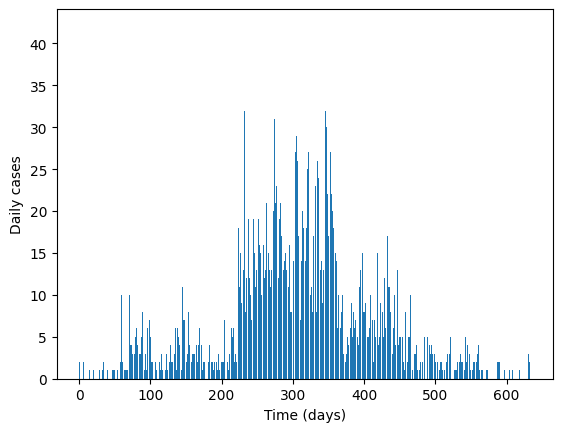

In [5]:
def daily_frequency(event_times):
    counter = Counter(event_times)
    keys = counter.keys()
    values = [counter[key] for key in keys]
    plt.bar(keys, values)
    plt.xlabel('Time (days)')
    plt.ylabel('Daily cases')

daily_frequency(date_nums_guinea)

We used the date onset inferred column of the given data. For a point process, we need the event times to be unique, so we will distribute multiple cases occurring on the same day evenly.

In [6]:
def distribute(data):
    """Distribute cases in the same day evenly

    Args:
        data (List(int)): A list of event times

    Returns:
        List: Distributed event times
    """
    counter = Counter(data)
    sorted_elements = sorted(counter.keys())
    time_ticks = []
    for e in sorted_elements:
        count = counter[e]
        for n in range(count):
            time_ticks.append(int(e)-1+(n+1)/count)
        
    return time_ticks

In [7]:
observed_guinea = distribute(date_nums_guinea)
observed_liberia = distribute(date_nums_liberia)
observed_sierra = distribute(date_nums_sierra)
print(date_nums_guinea)
print(observed_guinea)

[1, 1, 6, 6, 11, 15, 20, 25, 29, 32, 33, 34, 34, 35, 35, 38, 40, 42, 47, 48, 49, 50, 52, 52, 54, 55, 55, 56, 56, 58, 58, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 61, 61, 62, 62, 64, 65, 66, 66, 66, 66, 67, 68, 69, 69, 69, 70, 70, 70, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 72, 72, 72, 72, 73, 73, 73, 73, 74, 74, 74, 74, 75, 75, 75, 76, 77, 78, 78, 78, 79, 79, 79, 79, 79, 80, 80, 80, 80, 81, 81, 81, 81, 81, 81, 82, 82, 82, 82, 83, 83, 83, 83, 83, 83, 84, 84, 84, 84, 84, 84, 85, 85, 85, 86, 86, 86, 87, 87, 88, 88, 88, 88, 88, 89, 89, 89, 89, 89, 89, 89, 89, 91, 91, 91, 92, 93, 93, 93, 95, 96, 96, 96, 96, 96, 96, 97, 97, 97, 97, 98, 98, 98, 98, 98, 98, 98, 98, 98, 99, 99, 99, 99, 99, 99, 99, 100, 100, 100, 100, 100, 101, 101, 102, 102, 103, 103, 104, 104, 104, 105, 105, 107, 107, 108, 108, 108, 108, 109, 111, 112, 112, 113, 113, 114, 116, 116, 116, 117, 121, 122, 122, 122, 122, 123, 123, 123, 124, 125, 125, 125, 125, 126, 126, 127, 127, 128, 128, 128, 128, 129, 130, 130, 131, 131, 132, 134

## The Intensity Function

Want to reduce the number of summands in the self-exciting term to speed up the evaluation of the intensity function. Binary search is fast algorithm for sorted data to find the relevant set of events that contribute to the self-exciting term.

In [11]:
def binary_search(sorted_list, new):
    """Find the right position for a insertion"""
    left = 0
    right = len(sorted_list) - 1

    while left <= right:
        mid = (left + right) // 2
        if sorted_list[mid] == new:
            return mid
        elif sorted_list[mid] < new:
            left = mid + 1
        else:
            right = mid - 1
    return left

def history_n(t, event_times, n=50):
    """Reduce computations by ignoring all event times more than n days ago.
    Args:
        t: time
        n: number of days up to time t
        event_times (Iterable): event times 
    Returns:
        Iterable: all event times within n days of t
    """
    start = binary_search(event_times, t-n)
    end = binary_search(event_times,t)
    history_reduced = event_times[start:end]
    return history_reduced

In [8]:
def exponential_kernel(t, t_i, alpha, delta):
    return alpha*np.exp(-delta*(t-(t_i)))

def self_exciting_term(t, history, alpha, delta, dep=50):
    phi_sum = 0
    for t_i in history_n(t, history, dep):
        phi_sum += exponential_kernel(t, t_i, alpha, delta)
    return phi_sum

def intensity(t, history, alpha, delta, mu, dep=50):
    return mu + self_exciting_term(t, history, alpha, delta, dep)

Text(0.5, 1.0, 'Exponential kernel')

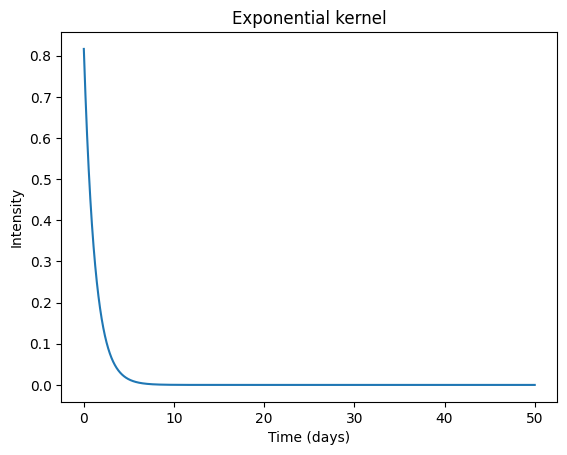

In [9]:
time50 = np.linspace(0,50,10000)
kernel_intensity = [exponential_kernel(t, 0, 0.81649203, 0.8209825) for t in time50]
plt.plot(time50, kernel_intensity)
plt.xlabel("Time (days)")
plt.ylabel("Intensity")
plt.title("Exponential kernel")

Text(0.5, 1.0, 'Intensity function, Guinea, Example parameters')

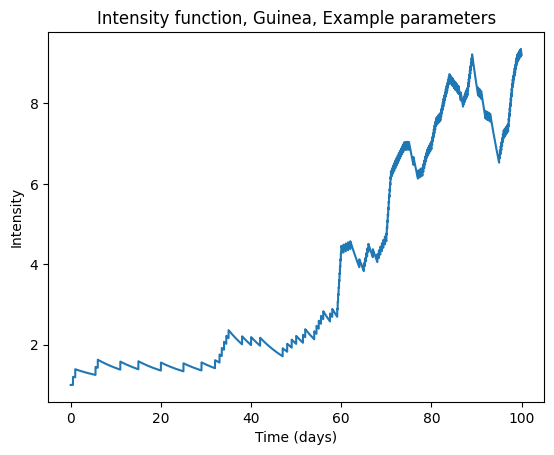

In [15]:
def intensity_plot(T, events, parameters):
    alpha, delta, mu = parameters
    time = np.arange(0,T,0.01)
    kernel_intensity = [intensity(t, events, alpha, delta, mu) for t in time]
    plt.plot(time, kernel_intensity)
    plt.xlabel("Time (days)")
    plt.ylabel("Intensity")
example_parameters = [0.2,0.1, 1]
intensity_plot(100, observed_guinea, example_parameters)
plt.title("Intensity function, Guinea, Example parameters")

## MLE Estimation

We wish to minimise the negative log likelihood function. Below is an implementation of the negative log likelihood function which uses numerical integration. Efforts were made to speed up the evaluation of this function and are explained in more detail in the "Problems encountered with maximum likelihood estimation" section. We then realised we could compute the integral exactly as we assumed an exponential kernel.

In [21]:
import time  
def llh_neg(parameters, event_times, T):
      def event_times_split(event_times, T):
            end = binary_search(event_times,T)
            event_times_T = np.array(event_times[:end])  # Get event times up to T
            split_times = np.split(event_times_T, np.arange(49, len(event_times_T), 49)) # Split event times into chunks of less than 50
            chunk_end = [split_times[i][-1] for i in range(len(split_times)-1)]
            chunk_beg = [split_times[i][0] for i in range(1, len(split_times))]
            integration_ends = [0] + [np.mean(pair) for pair in zip(chunk_end, chunk_beg)] + [T]
            return event_times_T, split_times, integration_ends

      event_times_T, event_times_50, bounds = event_times_split(event_times, T)
      #print(f"These are the event times up to time T: {event_times_T}")
      #print(f"These are the event times up to time T, broken into chunks of less than 50 events: {event_times_50}. "
            #f"and the lengths of each chunk are: {[len(chunk) for chunk in event_times_50]}")
      #print(f"These are the bounds for the integration: {bounds}")
      alpha, delta, mu = parameters
      start_time = time.time()
      integral_slices = []
      for i in range(len(bounds)-1):
            #print(event_times_50[i])
            #print(f"Discontinuities at {event_times_50[i]}")
            integral = spi.quad(lambda t: intensity(t, event_times_T, alpha, delta, mu),
                              bounds[i], bounds[i+1], points = event_times_50[i])[0]
            #print(f"Integrate intensity function between {bounds[i], bounds[i+1]} " 
                  #f"gives {integral}")
            integral_slices.append(integral)
      end_time = time.time()
      elapsed_time = end_time - start_time
      #print(f"Integration took {elapsed_time:.2f} seconds")
      #time = np.arange(0, 100, 0.01)
      #plt.plot(time, [intensity(t, event_times_T, alpha, delta, mu) for t in time])
      #print(f"These are the integral slices: {integral_slices}")
      integral_term = np.sum(integral_slices)
      #print(f"This is the integral_term: {integral_term}")

      log_terms = [np.log(intensity(t_i, event_times_T, alpha, delta, mu)) for t_i in event_times_T]
      #print(f"These are the log terms: {log_terms}")
      log_term = np.sum(log_terms)
      #print(f"This is the log term: {log_term}")
      
      return integral_term - log_term

In [22]:
def con1(x):
    return x[0]  # alpha > 0
def con2(x):
    return x[1]  # delta > 0
def con3(x):
    return x[2]  # mu > 0
cons = [
    {'type': 'ineq', 'fun': con1},
    {'type': 'ineq', 'fun': con2},
    {'type': 'ineq', 'fun': con3}
]
example_parameters = [0.5,0.5,1]
result = opt.minimize(llh_neg, example_parameters, args=(observed_guinea,100), constraints=cons)

optimized_params100 = result.x

print(f"Fitting the first 100 days of the Guinea cases." 
      f" alpha = {optimized_params100[0]}"
      f" delta = {optimized_params100[1]}"
      f" mu = {optimized_params100[2]}"
      )

C:\Users\akhma\AppData\Local\Temp\ipykernel_5228\743331711.py:23: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral = spi.quad(lambda t: intensity(t, event_times_T, alpha, delta, mu),
C:\Users\akhma\AppData\Local\Temp\ipykernel_5228\743331711.py:37: RuntimeWarning: invalid value encountered in log
  log_terms = [np.log(intensity(t_i, event_times_T, alpha, delta, mu)) for t_i in event_times_T]


Fitting the first 100 days of the Guinea cases. alpha = 0.13402804656535175 delta = 0.12195854245094663 mu = 0.2063533516992046
